# YCrCb image compression

Compressing color images with PNG in the YCrCb domain.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.axes as ax
#plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
import pylab
import math
import numpy as np
from scipy import signal
import cv2
import os
!ln -sf ~/quantization/deadzone_quantizer.py .
!ln -sf ~/quantization/midtread_quantizer.py .
!ln -sf ~/quantization/midrise_quantizer.py .
!ln -sf ~/quantization/distortion.py .
!ln -sf ~/quantization/information.py .
!ln -sf ~/MRVC/src/YCrCb.py .
!ln -sf ~/MRVC/src/debug.py .
!ln -sf ~/MRVC/src/image_3.py .
!ln -sf ~/MRVC/src/image_1.py .
!ln -sf ../common.py .
import deadzone_quantizer as Q
import midtread_quantizer as midtread
import midrise_quantizer as midrise
import YCrCb
import distortion
import information
import image_3 as RGB_img
import image_1 as gray_img
import colored
import common

## Configuration

In [2]:
# Prefix of the RGB image to be quantized.

home = os.environ["HOME"]
#fn = home + "/MRVC/sequences/stockholm/"
fn = home + "/MRVC/sequences/lena_color/"

components = ['R', 'G', 'B']

# Number of quantization steps.
N_QSs = 8
QSs = [256*i/N_QSs for i in range(1, N_QSs + 1)]
print(QSs)

[32.0, 64.0, 96.0, 128.0, 160.0, 192.0, 224.0, 256.0]


## Read the image and show it

image_3.read: /home/vruiz/MRVC/sequences/lena_color/000.png (512, 512, 3) uint8 512673 


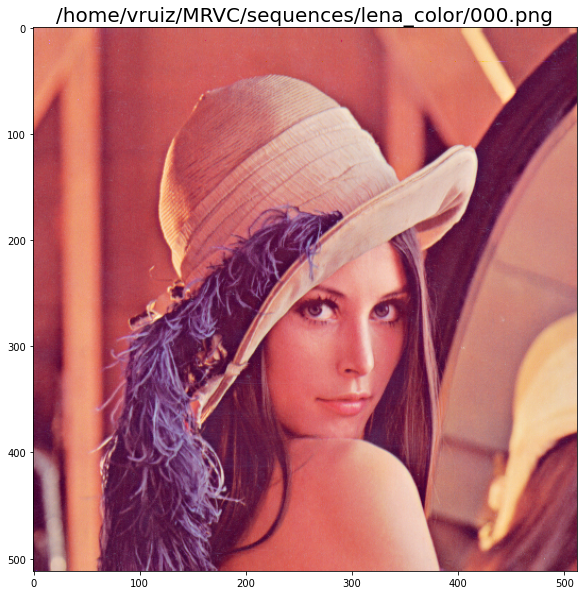

In [3]:
img = RGB_img.read(fn).astype(np.int16)
common.show(img, fn + "000.png")

## Show the components

In [14]:
R_avg_energy = information.average_energy(img[...,0])
G_avg_energy = information.average_energy(img[...,1])
B_avg_energy = information.average_energy(img[...,2])
print(f"Average energy R = {R_avg_energy}")
print(f"Average energy G = {G_avg_energy}")
print(f"Average energy B = {B_avg_energy}")
total_RGB_avg_energy = R_avg_energy + G_avg_energy + B_avg_energy
print(f"Total RGB average energy (computed by adding the energies of the components) = {total_RGB_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(img)*3}")
print(f"Total root average energy = {math.sqrt(total_RGB_avg_energy)}")

Average energy R = 34886.45802307129
Average energy G = 12608.167423248291
Average energy B = 12271.964656829834
Total RGB average energy (computed by adding the energies of the components) = 59766.590103149414
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414
Total root average energy = 244.47206405466744


The RGB domain is additive!

## YCrCb transform of a RGB image

In [15]:
YCrCb_img = YCrCb.from_RGB(img)
Y = YCrCb_img[...,0]
Cr = YCrCb_img[...,1]
Cb = YCrCb_img[...,2]

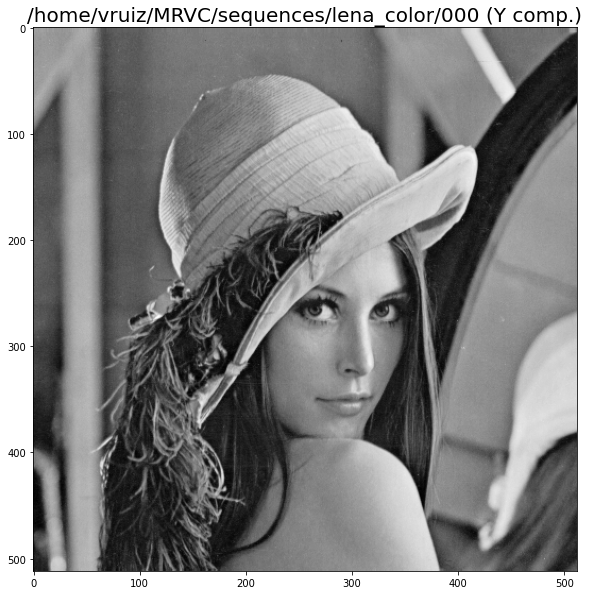

In [16]:
common.show_gray(Y, fn + "000 (Y comp.)")

In [17]:
print(Y.max(), Y.min())

245 25


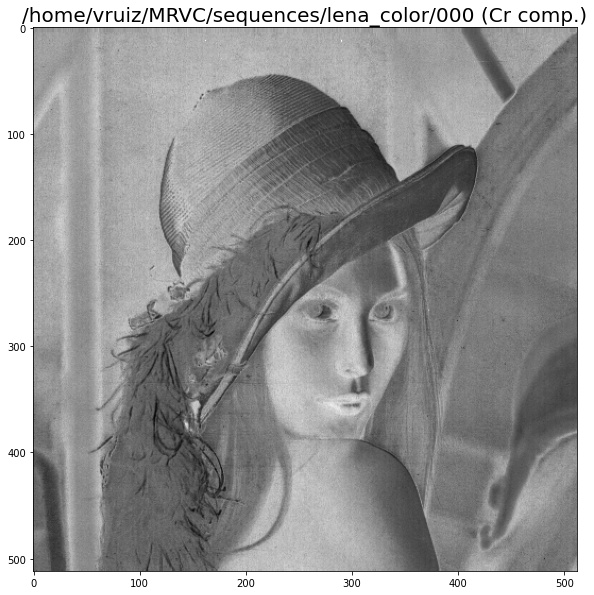

In [18]:
common.show_gray(Cr, fn + "000 (Cr comp.)")

In [19]:
print(Cr.max(), Cr.min())

211 121


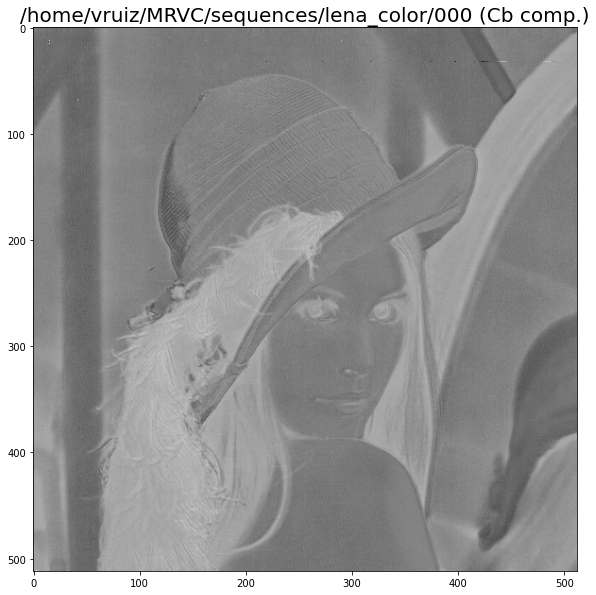

In [9]:
common.show_gray(Cb, fn + "000 (Cb comp.)")

In [10]:
print(Cb.max(), Cb.min())

198 27


The YCbCr components ranges between [0, 255].

## Components energy

In [20]:
Y_avg_energy = information.average_energy(Y)
Cr_avg_energy = information.average_energy(Cr)
Cb_avg_energy = information.average_energy(Cb)
print(f"Average energy in the Y image = {Y_avg_energy}")
print(f"Average energy in the Cr image = {Cr_avg_energy}")
print(f"Average energy in the Cb image = {Cb_avg_energy}")
total_YCrCb_avg_energy = Y_avg_energy + Cr_avg_energy + Cb_avg_energy
print(f"Total average energy (computed by adding the energies of the YCrCb components) = {total_YCrCb_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(img)*3}")

Average energy Y = 17678.79228591919
Average energy Cr = 28406.563133239746
Average energy Cb = 13989.699409484863
Total average energy (computed by adding the energies of the components) = 60075.0548286438
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414
Total root average energy = 245.1021314241143


Therefore, no, the YCrCb transform is not energy preserving.

## Let's compare to an orthonormal transform (Discrete Cosine Transform)

In [21]:
import numpy as np
from scipy.fftpack import dct, idct

DCT_type = 3
norm = "ortho" # Orthonormal: orthogonal + unitary (unit gain in both directions of the transform)
#norm = None

print(img[0,0,...])

DCT_img = np.empty_like(img)

[226 137 125]


In [22]:
for y in range(img.shape[1]):
    for x in range(img.shape[0]):
        DCT_img[y, x] = dct(img[y, x, ...], type=DCT_type, norm=norm)

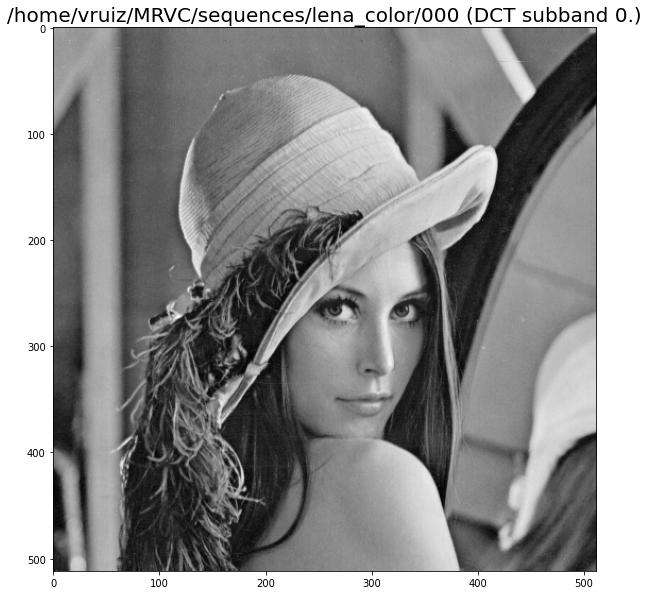

In [23]:
common.show_gray(DCT_img[..., 0], fn + "000 (DCT subband 0.)")

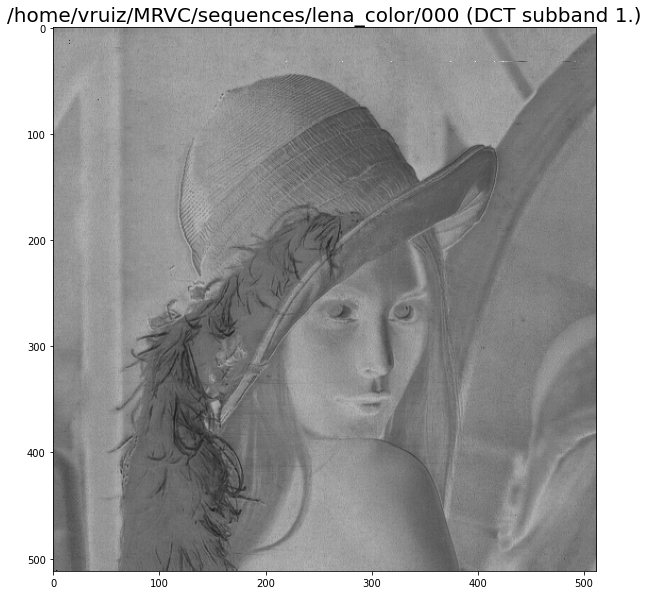

In [24]:
common.show_gray(DCT_img[..., 1], fn + "000 (DCT subband 1.)")

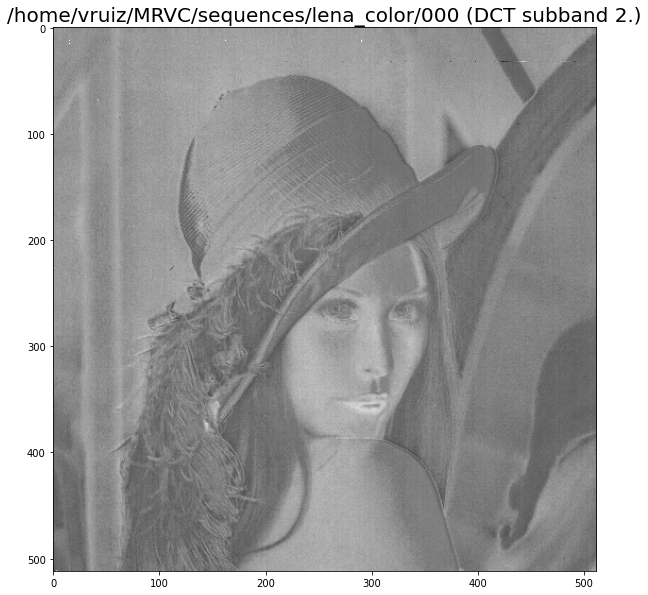

In [25]:
common.show_gray(DCT_img[..., 2], fn + "000 (DCT subband 2.)")

In [28]:
DCT_0_avg_energy = information.average_energy(DCT_img[..., 0])
DCT_1_avg_energy = information.average_energy(DCT_img[..., 1])
DCT_2_avg_energy = information.average_energy(DCT_img[..., 2])
print(f"Average energy DCT[..., 0] = {DCT_0_avg_energy}")
print(f"Average energy DCT[..., 1] = {DCT_1_avg_energy}")
print(f"Average energy DCT[..., 2] = {DCT_2_avg_energy}")
total_DCT_avg_energy = DCT_0_avg_energy + DCT_1_avg_energy + DCT_2_avg_energy
print(f"Total average energy (computed by adding the energies of the DCT coefficients) = {total_DCT_avg_energy}")
print(f"Total RGB average energy (computed directly from the RGB image) = {information.average_energy(img)*3}")

Average energy DCT[..., 0] = 52662.04672241211
Average energy DCT[..., 1] = 809.4176864624023
Average energy DCT[..., 2] = 5977.7565841674805
Total average energy (computed by adding the energies of the DCT coefficients) = 59449.22099304199
Total RGB average energy (computed directly from the RGB image) = 59766.590103149414


## Is the YCrCb transform reversible?

In [ ]:
YCrCb_img.shape

In [ ]:
img2 = YCrCb.to_RGB(YCrCb_img)

In [ ]:
np.array_equal(img, img2)

In [ ]:
print(img.max(), img.min())

In [ ]:
print(img2.max(), img2.min())

In [ ]:
print(YCrCb_img.max(), YCrCb_img.min(), np.average(YCrCb_img))

In [ ]:
common.show(img, "Original")

In [ ]:
common.show(img2, "Reconstructed")

In [ ]:
common.show(img-img2, "Reconstruction error")

The YCrCb transform is irreversible. In general, only integer arithmetic operations guarantees reversibility.

## Synthesis filters gains

The synthesis filters gains are important because the quantization steps of each YCrCb component should be adjusted in order to effectively provide the desired number of [bins](http://www.winlab.rutgers.edu/~crose/322_html/quantization.pdf) (different dequantized values) in each component.

Define a delta in the YCrCb domain (only the Y component with energy):

In [ ]:
val = 255
delta_Y = np.array([val, 0, 0]).astype(np.uint8).reshape(1,1,3)
delta_Y

With energy:

In [ ]:
energy_delta_Y = information.energy(delta_Y)
energy_delta_Y

Whose inverse transform is:

In [ ]:
RGB_delta_Y = YCrCb.to_RGB(delta_Y)
RGB_delta_Y

With energy:

In [ ]:
RGB_energy_delta_Y = information.energy(RGB_delta_Y)
RGB_energy_delta_Y

Define a delta in the YCrCb domain (only the Cr component with energy):

In [ ]:
delta_Cr = np.array([0, val, 0]).astype(np.uint8).reshape(1,1,3)
delta_Cr

With energy:

In [ ]:
energy_delta_Cr = information.energy(delta_Cr)
energy_delta_Cr

Whose inverse transform is:

In [ ]:
RGB_delta_Cr = YCrCb.to_RGB(delta_Cr)
RGB_delta_Cr

With energy:

In [ ]:
RGB_energy_delta_Cr = information.energy(RGB_delta_Cr)
RGB_energy_delta_Cr

Define a delta in the YCrCb domain (only the Cb component with energy):

In [ ]:
delta_Cb = np.array([0, 0, val]).astype(np.uint8).reshape(1,1,3)
delta_Cb

With energy:

In [ ]:
energy_delta_Cb = information.energy(delta_Cb)
energy_delta_Cb

Whose inverse transform is:

In [ ]:
RGB_delta_Cb = YCrCb.to_RGB(delta_Cb)
RGB_delta_Cb

With energy:

In [ ]:
RGB_energy_delta_Cb = information.energy(RGB_delta_Cb)
RGB_energy_delta_Cb

Now, let's see if the components are additive (the transform is orthogonal):

In [ ]:
delta_YCrCb = np.array([val, val, val]).astype(np.uint8).reshape(1,1,3)
delta_YCrCb

In [ ]:
energy_delta_YCrCb = information.energy(delta_YCrCb)
energy_delta_YCrCb

In [ ]:
RGB_delta_YCrCb = YCrCb.to_RGB(delta_YCrCb)
RGB_delta_YCrCb

In [ ]:
RGB_energy_delta_YCrCb = information.energy(RGB_delta_YCrCb)
RGB_energy_delta_YCrCb

In [ ]:
RGB_energy_delta_Y + RGB_energy_delta_Cr + RGB_energy_delta_Cb

Unfortunately, the YCrCb transform is not orthogonal and therefore, the different components are not additive. Moreover, the relative gain of the YCrCb components depends on their magnitude, which makes that those gains do not match with the theoretical ones.

In [ ]:
print(RGB_energy_delta_Y/RGB_energy_delta_Cr, 3/2.4754)

In [ ]:
print(RGB_energy_delta_Y/RGB_energy_delta_Cb, 3/3.25832)

Anyway, the main drawback of the lack of orthogonality and is that it can not be assumed that the quantization noise generated in one of the YCrCb components will produce a proportional amount of distortion in the reconstruction. Therefore, to compute such distortion, the inverse YCrCb transform should be used.

## How orthogonality affects?
Let's see why if the transform where orthogonal (or even better, orthonormal (orthogonal + unitary (unit gain in both directions of the transform))) the contributions of the coefficients to the energy of the pixel are independent. This is true for example for the [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform).

In [ ]:
import numpy as np
from scipy.fftpack import dct, idct

val = 10
DCT_type = 3
norm = "ortho" # Orthonormal: orthogonal + unitary (unit gain in both directions of the transform)
#norm = None

In [ ]:
delta_0_DCT = np.array([val, 0., 0.])
delta_0_DCT

In [ ]:
information.energy(delta_0_DCT)

In [ ]:
RGB_delta_0_DCT = idct(delta_0_DCT, type=DCT_type, norm=norm)
RGB_delta_0_DCT

In [ ]:
information.energy(RGB_delta_0_DCT)

The energy is preserved.

In [ ]:
delta_1_DCT = np.array([0., val, 0.])
delta_1_DCT

In [ ]:
information.energy(delta_1_DCT)

In [ ]:
RGB_delta_1_DCT = idct(delta_1_DCT, type=DCT_type, norm=norm)
RGB_delta_1_DCT

In [ ]:
information.energy(RGB_delta_1_DCT)

The energy is preserved.

In [ ]:
delta_2_DCT = np.array([0., 0., val])
delta_2_DCT

In [ ]:
information.energy(delta_2_DCT)

In [ ]:
RGB_delta_2_DCT = idct(delta_2_DCT, type=DCT_type, norm=norm)
RGB_delta_2_DCT

In [ ]:
information.energy(RGB_delta_2_DCT)

The energy is preserved.

In [ ]:
delta_DCT = np.array([val, val, val])
delta_DCT

In [ ]:
information.energy(delta_DCT)

In [ ]:
RGB_delta_DCT = idct(delta_DCT, type=DCT_type, norm=norm)
RGB_delta_DCT

In [ ]:
information.energy(RGB_delta_DCT)

The DCT coefficients are additive.

### Energy of the RGB channels

In [ ]:
R_energy = information.energy(img[...,0])
G_energy = information.energy(img[...,1])
B_energy = information.energy(img[...,2])
RGB_energy = information.energy(img)
print("Energy of R =", R_energy)
print("Energy of G =", G_energy)
print("Energy of B =", B_energy)
print("Energy of the RGB image =", RGB_energy, R_energy + G_energy + B_energy)

The RGB domain is additive.

### Energy of the YCrCb channels

In [ ]:
YCrCb_frame = YCrCb.from_RGB(img.astype(np.uint8))
Y_energy = information.energy(YCrCb_frame[...,0])
Cr_energy = information.energy(YCrCb_frame[...,1])
Cb_energy = information.energy(YCrCb_frame[...,2])
YCrCb_energy = information.energy(YCrCb_frame)
print("Energy of Y =", Y_energy)
print("Energy of Cr =", Cr_energy)
print("Energy of Cb =", Cb_energy)
print("Energy of the YCrCb image =", YCrCb_energy, Y_energy + Cr_energy + Cb_energy)

Joder

In [ ]:
def same_delta_RD_curve(YCrCb_img, Q_steps, quantizer):
    points = []
    for Q_step in Q_steps:
        y, k = quantizer.quan_dequan(YCrCb_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_color_pixel(k, str(Q_step) + '_') # OJO!!!!!!!!!!!
        _distortion = distortion.MSE(RGB_img, y)
        points.append((rate, _distortion))
        print(f"q_step={Q_step:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

same_delta_RD_points = same_delta_RD_curve(img, Q_steps, quantizer)

## Generation of the (sub-optimal) RD curve

The RD curve can be generated with:

1. Convert the image from RGB to YCrCb.
2. The RD curve of each YCrCb channel is computed, for a number of quantization steps. We will compute two different curves for each component, one using the same QSs, and other using the QSs adapted to the gain of the component.
3. The OTP (Optimal Truncation Points) are sorted by slopes.

Notice that because the contribution of the YCrCb components are not independent, we will get a sub-optimal RD curve using this technique. The alternative would be a brute-force search algorithm.

## Build the optimal RD curve

Neither YCrCb nor YCoCg are orthogonal spaces, which means that even considering the channel gains, the contributions of the channels to the quality of the reconstruction are not additive (the channels are not independent). This implies that the search of the optimal QSs cannot be done by simply sorting the slopes of each OTP of each channel, but by searching for each OTP the best combination of QSs, that not necessarily need to be embbeded (i.e., it can not be asserted that the optimal QSs for a quality level Q generated by a combination $[\Delta_Y^Q, \Delta_U^Q, \Delta_V^Q]$ > $[\Delta_Y^{Q+1}, \Delta_U^{Q+1}, \Delta_V^{Q+1}]$, for all the channels). Unfortunately, this fact significantly complicates the optimal bit-rate control through quantization. 

A way to deal with this problem is ignore the orthogonality lack (well, the YCoCg transform is almost orthogonal, and therefore, we are not supposing something terribly wrong). This is that we are going to implement.

## RD curves of each YCrCb channel ($\Delta_\text{Y}=\Delta_\text{Cr}=\Delta_\text{Cb}$)

Notice that we compute the distortion in the RGB domain because the transform is not orthogonal. The bit-rate is computed using only the corresponding channel. Remember that the quantization indexes images need to be normalized or equalized to be displayed properly.

In [ ]:
def Y_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 256):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Y_img = YCrCb_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        k, dequantized_Y_img = Q.quan_dequan(Y_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Y' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCrCb_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Y', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cr_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cr_img = YCrCb_img[:,:,1]
        dequantized_Cr_img = np.empty_like(Cr_img)
        k, dequantized_Cr_img = Q.quan_dequan(Cr_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cr' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cr_img, dequantized_Cr_img)
        YCrCb_img[...,1] = dequantized_Cr_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Cr', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cb_RD_curve_same_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cb_img = YCrCb_img[:,:,2]
        dequantized_Cb_img = np.empty_like(Cb_img)
        k, dequantized_Cb_img = Q.quan_dequan(Cb_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cb_img, dequantized_Cb_img)
        YCrCb_img[...,2] = dequantized_Cb_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Y_points_same_deltas = Y_RD_curve_same_deltas(img, QSs)
Cr_points_same_deltas = Cr_RD_curve_same_deltas(img, QSs)
Cb_points_same_deltas = Cb_RD_curve_same_deltas(img, QSs)

## RD curves of each YCrCb channel ($\frac{3}{2.4754}\Delta_\text{Y}=\Delta_\text{Cr}=\frac{3.25832}{2.4754}\Delta_\text{Cb}$)

Relative gains of each component:

* For Y: $3/2.4754=1.21192534539872343863$
* For Cr: $2.4754/2.4754=1$
* For Cb: $3.25832/2.4754=1.31628019713985618485$

The QSs are divided by these relative gains.

In [ ]:
def Y_RD_curve_gain_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Y_img = YCrCb_img[:,:,0]
        dequantized_Y_img = np.empty_like(Y_img)
        Q_step /= 1.21192534539872343863
        k, dequantized_Y_img = Q.quan_dequan(Y_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Yrb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Y_img, dequantized_Y_img)
        YCrCb_img[...,0] = dequantized_Y_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion, 'Yrb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

def Cb_RD_curve_gain_deltas(RGB_img, QSs):
    RD_points = []
    for Q_step in range(1, 128):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        Cb_img = YCrCb_img[:,:,2]
        dequantized_Cb_img = np.empty_like(Cb_img)
        Q_step /= 1.31628019713985618485
        k, dequantized_Cb_img = Q.quan_dequan(Cb_img, Q_step)
        rate = common.bits_per_gray_pixel(k, 'Cb' + str(Q_step) + '_')
        #_distortion = distortion.MSE(Cb_img, dequantized_Cb_img)
        YCrCb_img[...,2] = dequantized_Cb_img
        dequantized_RGB_img = YCrCb.to_RGB(YCrCb_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        RD_points.append((rate, _distortion, 'Cb', Q_step))
        print(f"q_step={Q_step:>3}, rate={rate:.3f} bits/pixel, distortion={_distortion}")
    return RD_points

Y_points_gain_deltas = Y_RD_curve_gain_deltas(img, QSs)
Cb_points_gain_deltas = Cb_RD_curve_gain_deltas(img, QSs)

In [ ]:
pylab.figure(dpi=150)
#pylab.plot(*zip(*YCrCb_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}} = \Delta_{\mathrm{Cr}} = \Delta_{\mathrm{Cb}}$')
pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_same_deltas]), c='r', marker=".", s=0.5, label='Y',)              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cr_points_same_deltas]), c='g', marker=".", s=0.5, label='Cr')              
pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_same_deltas]), c='b', marker=".", s=0.5, label='Cb')              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Y_points_gain_deltas]), c='r', marker=".", s=0.5, label='Only Y', linestyle="dotted")              
#pylab.scatter(*zip(*[(i[0], i[1]) for i in Cb_points_gain_deltas]), c='b', marker=".", s=0.5, label='Only Cb', linestyle="dotted")              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

Conclusions:
1. The distortions are not additive.
2. The slopes of the curves for different quantization steps are different.

## Compute the slopes
In a different list for each component.

In [ ]:
Yrb_slopes = common.compute_slopes(Yrb_points)
Cr_slopes = common.compute_slopes(Cr_points)
Cb_slopes = common.compute_slopes(Cb_points)

## Merge the RD slopes and sort them
By slope.

In [ ]:
all_YCrCb_slopes = Yrb_slopes + Cr_slopes + Cb_slopes
sorted_YCrCb_slopes = sorted(all_YCrCb_slopes, key=lambda x: x[0])[::-1]

## Build the RD curve

Progressively quantize the image using the Q_steps described in the sorted list of monotonously decreasing slopes, and then, compute the distortion and the bit-rate. Remember that the quantization indexes images must be normalized or equalized to be displayed properly, and also, that they are in the YUV domain.

In [ ]:
# Falta hacer la transformada!!

def YCrCb_get_suboptimal_RD_curve(RGB_img, sorted_slopes, components):
    points = []
    Q_steps_per_component = [256, 256, 256] # This should generate a black image.
    k = np.empty_like(RGB_img)
    y = np.empty_like(RGB_img)
    YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
    for i in sorted_slopes:
        point = i[1]
        component = point[2]
        Q_step = point[3]
        Q_steps_per_component[components.index(component)] = Q_step
        #print(i, Q_steps_per_component)
        for c,Q_step in zip(components, Q_steps_per_component):
            k[..., components.index(c)], y[..., components.index(c)] = q_deq(YCrCb_img[..., components.index(c)], Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k, str(Q_steps_per_component) + '_')
        #_distortion = distortion.MSE(YCrCb_img, y)
        #YCoCg_img[...,2] = dequantized_Cg_img
        dequantized_RGB_img = YCrCb.to_RGB(y)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)        
        points.append((rate, _distortion))
        print(f"Q_step={Q_steps_per_component}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return points

YCrCb_suboptimal_points = YCrCb_get_suboptimal_RD_curve(img, sorted_YCrCb_slopes, ['Yrb', 'Cr', 'Cb'])

## Optimal quantization in the RGB domain
See [RGB_quantization.ipynb](file:///home/vruiz/Sistemas-Multimedia.github.io/milestones/05-RGB_quantization/RGB_quantization.ipynb).

In [ ]:
RGB_points = []
with open('../05-RGB_quantization/RGB.txt', 'r') as f:
    #rate, _distortion = f.read()
    #RGB_points.append((rate, _distortion))
    for line in f:
        rate, _distortion = line.split('\t')
        RGB_points.append((float(rate), float(_distortion)))

## RD curve using same $\Delta$ for each YCrCb channel ($\Delta_{\text{Y}} = \Delta_{\text{Cr}} = \Delta_{\text{Cb}}$)

In [ ]:
def YCrCb_RD_curve_same_delta(RGB_img):
    RD_points = []
    for q in range(0, 8):
        YCrCb_img = YCrCb.from_RGB(RGB_img.astype(np.uint8))
        #YCrCb_img = YCrCb_img.astype(np.int16)
        k, dequantized_YCrCb_img = Q.quan_dequan(YCrCb_img, 1<<q)
        k = k.astype(np.uint8)
        #show(dequantized_YCrCb_img, q_step)
        rate = common.bits_per_RGB_pixel(k, "YCrCb" + str(1<<q) + "_")
        dequantized_RGB_img = YCrCb.to_RGB(dequantized_YCrCb_img.astype(np.uint8))
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={1<<q:>3}, rate={rate:>7} bits/pixel, distortion={_distortion:>6.1f}")
    return RD_points

YCrCb_points_same_delta = YCrCb_RD_curve_same_delta(img)

In [ ]:
with open('YCrCb.txt', 'w') as f:
    for item in YCrCb_points_same_delta:
        f.write(f"{item[0]}\t{item[1]}\n")

## Let's compare!

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_points), marker=".", label="$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}}$")
pylab.scatter(*zip(*YCrCb_points_same_delta), marker="o", label="$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}}$")
#pylab.scatter(*zip(*YCrCb_suboptimal_points), marker="o", label="Suboptimal YCrCb")
pylab.title("Rate/Distortion Performance ")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
pylab.legend(loc='upper right')
pylab.show()

## Conclusions:
1. In general, quantization is more effective in the transformed domain.
2. At low bit-rates, it's better to quantize in YCoCb domain than to quantize in the YCrCb one. 

### RD using channel gains in YCoCg domain

In [ ]:
def YCoCg_RD_curve(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        #k, dequantized_YCoCg_img = q_deq(YCoCg_img, 1<<q_step)
        k, dequantized_YCoCg_img = common.q_deq(YCoCg_img, Q_step)
        k = k.astype(np.uint8)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_points = YCoCg_RD_curve(img)

relative_Y_gain = 3/2
relative_Co_gain = 1
relative_Cg_gain = 3/2
def YCoCg_RD_curve_with_gains(RGB_img):
    RD_points = []
    #for q_step in range(0, 8):
    for Q_step in range(1, 256):
        YCoCg_img = YCoCg.from_RGB(RGB_img.astype(np.int16))
        dequantized_YCoCg_img = np.empty_like(YCoCg_img)
        k = np.empty_like(YCoCg_img, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_img[:,:,0] = common.q_deq(YCoCg_img[:,:,0], (Q_step)/relative_Y_gain)
        k[:,:,1], dequantized_YCoCg_img[:,:,1] = common.q_deq(YCoCg_img[:,:,1], (Q_step)/relative_Co_gain)
        k[:,:,2], dequantized_YCoCg_img[:,:,2] = common.q_deq(YCoCg_img[:,:,2], (Q_step)/relative_Cg_gain)
        print((Q_step)/relative_Cg_gain)
        #k[0], dequantized_YCoCg_img[0] = q_deq(YCoCg_img[0], q_step/relative_Y_gain)
        #k[1], dequantized_YCoCg_img[1] = q_deq(YCoCg_img[1], q_step/relative_Co_gain)
        #k[2], dequantized_YCoCg_img[2] = q_deq(YCoCg_img[2], q_step/relative_Cg_gain)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_RGB_img = YCoCg.to_RGB(dequantized_YCoCg_img)
        _distortion = distortion.MSE(RGB_img, dequantized_RGB_img)
        RD_points.append((rate, _distortion))
        print(f"Q_step={Q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YCoCg_gains_points = YCoCg_RD_curve_with_gains(img)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*YCoCg_points), c='r', marker=".", s=0.5,
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.scatter(*zip(*YCoCg_gains_points), c='b', marker="x", s=1,
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(relative_Y_gain) + '\Delta_{\mathrm{Cg}}' +
           ';\Delta_{\mathrm{Cg}}=' + "{:3.1f}".format(relative_Cg_gain) + '\Delta_{\mathrm{Co}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

### Comparing the three domains using the same quantization steps

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), c='b', marker="x",
           label='$\Delta_{\mathrm{R}}=\Delta_{\mathrm{G}}=\Delta_{\mathrm{B}}$')
#pylab.plot(*zip(*YCrCb_points), c='r', marker="x",
#           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
#pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
#           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
#           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("Performance of Quantization in Different Domains")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
Cr_gain = 1.0 # 2.4754
Cb_gain = 3.25832/2.4754
Y_gain = 3/2.4754
def YYCrCb_RD_curve_with_gains(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        YYCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YYCrCb_frame = np.empty_like(YYCrCb_frame)
        k = np.empty_like(YYCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YYCrCb_frame[:,:,0] = common.q_deq(YYCrCb_frame[:,:,0], (1<<q_step)/Y_gain)
        k[:,:,1], dequantized_YYCrCb_frame[:,:,1] = common.q_deq(YYCrCb_frame[:,:,1], (1<<q_step)/Cr_gain)
        k[:,:,2], dequantized_YYCrCb_frame[:,:,2] = common.q_deq(YYCrCb_frame[:,:,2], (1<<q_step)/Cb_gain)
        rate = common.bits_per_RGB_pixel(k)
        dequantized_YYCrCb_frame = dequantized_YYCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YYCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
        print(f"q_step={1<<q_step:>3}, rate={rate:>7} BPS, distortion={_distortion:>6.1f}")
    return RD_points

YYCrCb_gains_points = YYCrCb_RD_curve_with_gains(img)

Conclusions:
1. In general, quantization is more effective in the transformed domain considering the RD plane.
2. $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ is slightly better than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$, at low bit-rates, and viceversa.
3. At low bit-rates, tt's better to quantize YCoCb than to quantize YCrCb. 

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ the best quantization in YCrCb?
No, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ is better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at high bit-rates.

## Is $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ optimal at low bit-rates quantizing YCrCb?

In [ ]:
N=5
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cb_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cr_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCrCb_frame = YCrCb.from_RGB(RGB_frame.astype(np.uint8))
        dequantized_YCrCb_frame = np.empty_like(YCrCb_frame)
        k = np.empty_like(YCrCb_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCrCb_frame[:,:,0] = q_deq(YCrCb_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCrCb_frame[:,:,1] = q_deq(YCrCb_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCrCb_frame[:,:,2] = q_deq(YCrCb_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_YCrCb_frame = dequantized_YCrCb_frame.astype(np.uint8)
        assert dequantized_YCrCb_frame.all() >= 0
        dequantized_RGB_frame = YCrCb.to_RGB(dequantized_YCrCb_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Cb_points = only_Cb_RD_curve(img)
only_Cr_points = only_Cr_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YYCrCb_gains_points), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cb_points), c='g', marker="o",
           label='$\Delta_{\mathrm{Cb}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cr_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cr}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<N))              
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

No, there are combinations of $\Delta_{\mathrm{Y}}$, $\Delta_{\mathrm{Cr}}$, and $\Delta_{\mathrm{Cb}}$ better than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}}; \Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$ at low bit-rates.

## Is $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ optimal quantizing YCoCb?

In [ ]:
N=4
def only_Y_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        #k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        #k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Co_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<q_step)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<N)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

def only_Cg_RD_curve(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCoCg_frame = YCoCg.from_RGB(RGB_frame.astype(np.int16))
        dequantized_YCoCg_frame = np.empty_like(YCoCg_frame)
        k = np.empty_like(YCoCg_frame, dtype=np.uint8)
        k[:,:,0], dequantized_YCoCg_frame[:,:,0] = q_deq(YCoCg_frame[:,:,0], 1<<N)
        k[:,:,1], dequantized_YCoCg_frame[:,:,1] = q_deq(YCoCg_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCoCg_frame[:,:,2] = q_deq(YCoCg_frame[:,:,2], 1<<q_step)
        rate = bits_per_RGB_pixel(k)
        dequantized_RGB_frame = YCoCg.to_RGB(dequantized_YCoCg_frame)
        _distortion = distortion.MSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, _distortion))
    return RD_points

only_Y_points = only_Y_RD_curve(img)
only_Co_points = only_Co_RD_curve(img)
only_Cg_points = only_Cg_RD_curve(img)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*only_Y_points), c='r', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Co_points), c='m', marker="o",
           label='$\Delta_{\mathrm{Co}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cg}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*only_Cg_points), c='b', marker="o",
           label='$\Delta_{\mathrm{Cg}}~\mathrm{varies},~\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=$' + '{}'.format(1<<N))              
pylab.plot(*zip(*YCoCg_points), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$')
pylab.title("RD Performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

At least, using the same experiment than before, $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Co}}=\Delta_{\mathrm{Cg}}$ seems to be near optimal quantizing YCoCb.

## Ignore the rest ...

## Some experiments showing the impact of the lack of orthogonality

In [ ]:
def _YCbCr_RD_curve(RGB_frame, N):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        dequantized_YCbCr_frame = np.empty_like(YCbCr_frame)
        k = np.empty_like(YCbCr_frame)
        k[:,:,0], dequantized_YCbCr_frame[:,:,0] = q_deq(YCbCr_frame[:,:,0], 1<<q_step)
        k[:,:,1], dequantized_YCbCr_frame[:,:,1] = q_deq(YCbCr_frame[:,:,1], 1<<N)
        k[:,:,2], dequantized_YCbCr_frame[:,:,2] = q_deq(YCbCr_frame[:,:,2], 1<<N)
        rate = bytes_per_color_frame(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

_YCbCr_points_8 = _YCbCr_RD_curve(frame, 8)
_YCbCr_points_7 = _YCbCr_RD_curve(frame, 7)
_YCbCr_points_6 = _YCbCr_RD_curve(frame, 6)
_YCbCr_points_5 = _YCbCr_RD_curve(frame, 5)
_YCbCr_points_4 = _YCbCr_RD_curve(frame, 4)
_YCbCr_points_3 = _YCbCr_RD_curve(frame, 3)

In [ ]:
1<<4

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*YCbCr_points), c='r', marker="x",
           label='$\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$')
pylab.plot(*zip(*_YCbCr_points_8), c='b', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<8))
pylab.plot(*zip(*_YCbCr_points_7), c='g', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<7))
pylab.plot(*zip(*_YCbCr_points_6), c='c', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<6))
pylab.plot(*zip(*_YCbCr_points_5), c='m', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<5))
pylab.plot(*zip(*_YCbCr_points_4), c='y', marker="x",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<4))
pylab.plot(*zip(*_YCbCr_points_3), c='k', marker="o",
           label='$\Delta_{\mathrm{Y}}~\mathrm{varies},~\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}=$' + '{}'.format(1<<3))
pylab.plot(*zip(*YCbCr_gains_points), c='m', marker="+",
           label='$\Delta_{\mathrm{Y}}=' + "{:3.1f}".format(Y_gain) + '\Delta_{\mathrm{Cr}}' +
           ';\Delta_{\mathrm{Cb}}=' + "{:3.1f}".format(Cb_gain) + '\Delta_{\mathrm{Cr}}$')
pylab.title("The lack of non-orthogonality in the YCrCb transform")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

From this experiment we conclude that:
1. The luma should not be "deleted" from the code-stream (see curve $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$).
2. There are better combinations than $\Delta_{\mathrm{Y}}=\Delta_{\mathrm{Cr}}=\Delta_{\mathrm{Cb}}$ and $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

### YCrCb

It's possible to find better combinations than $\Delta_{\mathrm{Y}}=1.2\Delta_{\mathrm{Cr}};\Delta_{\mathrm{Cb}}=1.3\Delta_{\mathrm{Cr}}$.

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCbCr(frame.astype(np.uint8))
ycc[:,:,0] = 0
frame2 = YCbCr_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCbCr domain)")

### YCoCg

Notice that, at least visually, it does not make sense to use $\Delta_{\mathrm{Y}}\ge 8$ because the reconstructed image will be very dark or even black. The same holds for YCoCg.

In [ ]:
ycc = RGB_to_YCoCg(frame)
ycc[:,:,0]= 0
frame2 = YCoCg_to_RGB(ycc)
print(frame2.min(), frame2.max())
show_frame(frame2, "$\Delta_{\mathrm{Y}} \ge 8$" + " (YCoCg domain)")

In [ ]:
def YCbCr_RD_curve_only_Y(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,1] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        k[:,:,0] = 0
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cb(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,2] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

def YCbCr_RD_curve_only_Cr(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint8))
        YCbCr_frame[:,:,0] = 0
        YCbCr_frame[:,:,1] = 0
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint8)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

only_Y_curve = YCbCr_RD_curve_only_Y(frame)
only_Cb_curve = YCbCr_RD_curve_only_Cb(frame)
only_Cr_curve = YCbCr_RD_curve_only_Cr(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*only_Y_curve), s=2, c='r', marker="o", label='only Y')
pylab.plot(*zip(*only_Y_curve), c='r', marker="o")
pylab.scatter(*zip(*only_Cb_curve), s=2, c='g', marker="o", label='only Cb')
pylab.plot(*zip(*only_Cb_curve), c='g', marker="o")
pylab.scatter(*zip(*only_Cr_curve), s=2, c='b', marker="o", label='only Cr')
pylab.plot(*zip(*only_Cr_curve), c='b', marker="o")
pylab.title("R/D Performance")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
def YCbCr_RD_curve_2(RGB_frame):
    RD_points = []
    for q_step in range(0, 8):
        print(q_step, end=' ')
        YCbCr_frame = RGB_to_YCbCr(RGB_frame.astype(np.uint16))
        YCbCr_frame[:,:,1] //= 2
        YCbCr_frame[:,:,2] //= 2
        k, dequantized_YCbCr_frame = q_deq(YCbCr_frame, 1<<q_step)
        dequantized_YCbCr_frame[:,:,1] *= 2
        dequantized_YCbCr_frame[:,:,2] *= 2
        rate = byte_rate(k)
        dequantized_YCbCr_frame = dequantized_YCbCr_frame.astype(np.uint16)
        dequantized_RGB_frame = YCbCr_to_RGB(dequantized_YCbCr_frame)
        distortion = RMSE(RGB_frame, dequantized_RGB_frame)
        RD_points.append((rate, distortion))
    return RD_points

YCbCr_quantization_2 = YCbCr_RD_curve_2(frame)

In [ ]:
pylab.figure(dpi=150)
pylab.scatter(*zip(*RGB_quantization), s=2, c='b', marker="o", label='RGB quantization')
pylab.plot(*zip(*RGB_quantization), c='b', marker="o")
pylab.scatter(*zip(*YCbCr_quantization), s=2, c='r', marker="o", label='YCbCr quantization')
pylab.plot(*zip(*YCbCr_quantization), c='r', marker="o")
pylab.scatter(*zip(*YCbCr_quantization_2), s=2, c='g', marker="o", label='YCbCr quantization 2')
pylab.plot(*zip(*YCbCr_quantization_2), c='g', marker="o")
pylab.title("R/D Only Quantization")
pylab.xlabel("Bytes/Frame")
pylab.ylabel("RMSE")
plt.legend(loc='upper right')
pylab.show()

In [ ]:
YCbCr_test_frame = np.array([255, 0, 0], dtype=np.int16).reshape((1,1,1))
print(YCbCr_to_RGB(YCbCr_test_frame))

In [ ]:
np.array([255, 0, 0], dtype=np.int16)

In [ ]:
YCbCr_test_frame = np.zeros_like(frame).astype(np.uint16)

In [ ]:
type(YCbCr_test_frame[0,0,0])

In [ ]:
YCbCr_test_frame[1,1,2] = 255

In [ ]:
RGB_test_frame = YCbCr_to_RGB(YCbCr_test_frame)

In [ ]:
print(average_energy(RGB_test_frame))

In [ ]:
show_frame(RGB_test_frame, "")